In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

In [12]:
torch.set_default_dtype(torch.double)
use_cuda = True
device = torch.device("cuda:0" if use_cuda and torch.cuda.is_available() else "cpu")

In [13]:
class DatasetBase(Dataset):

    def set_values(self, values):
        if not isinstance(values, torch.Tensor):
            values = torch.tensor(values)
        if values.shape != torch.Size([values.shape[0]]):
            raise Exception(f"单变量适用{values.shape=}")
        self.values = values

In [14]:
class SimpleDataset(DatasetBase):

    def __init__(self, P, F, values):
        self.P = P
        self.F = F
        self.set_values(values)

    def __getitem__(self, index):
        X_S = self.values[index : index + self.P]
        Y_S = self.values[index + self.P : index + self.P + self.F]
        return X_S, Y_S

    def __len__(self):
        return len(self.values) - self.P - self.F + 1

In [15]:
class PeriodsSegmentDataset(Dataset):

    def __init__(self, F, L, M, values, k):
        # values is [N]

        self.F = F
        self.L = L
        self.M = M
        self.k = k
        self.values = values
        self.N = len(self.values)
        self.e = self.segment_interval()

    def __getitem__(self, i):
        # X_S
        segments = []
        for j in range(self.M):
            seg_starts = i + j * self.e
            seg_ends = i + j * self.e + self.L
            # print(f"{seg_starts=},{seg_ends=}")
            segment = self.values[seg_starts:seg_ends]
            segments.append(segment)
        X_S = torch.cat(segments)
        # Y_S
        Y_S_starts = i + (self.M - 1) * self.e + self.L
        Y_S_ends = i + (self.M - 1) * self.e + self.L + self.F
        # print(f"{Y_S_starts=},{Y_S_ends=}")
        Y_S = self.values[Y_S_starts:Y_S_ends]
        return X_S, Y_S

    def __len__(self):
        return len(self.values) - (self.M - 1) * self.e - self.L - self.F + 1

    def segment_interval(self) -> int:
        a = torch.abs(torch.fft.fft(self.values)[: self.N // 2])
        a[0] = 0
        z = torch.arange(self.N)[: self.N // 2]
        indices = torch.topk(a, self.k).indices
        l_a = a[indices]
        l_z = z[indices]
        e = int(2 * sum(l_a * l_a) / sum(l_a * l_z))
        return e

In [16]:
df = pd.read_csv("../dataset/ETTh1.csv")

torch.Size([17420])

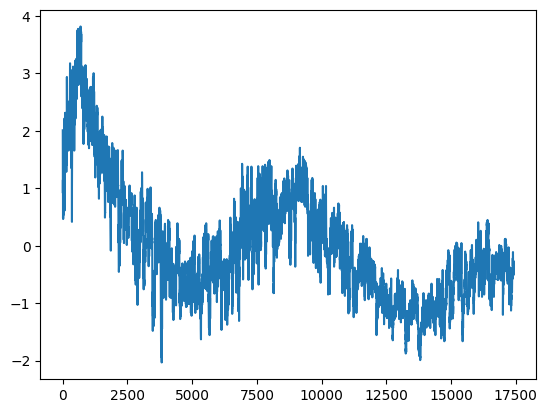

In [17]:
from sklearn.preprocessing import StandardScaler as Scaler

scaler = Scaler()

# [P]->[C=1,P]
values = torch.tensor(df["OT"].to_numpy()).unsqueeze(1)

values = scaler.fit_transform(values)

values = torch.tensor(values).squeeze(1)

plt.plot(values.numpy())
values.shape

In [18]:
def train(dataset, model, num_epochs):

    loss_list = []

    model = model.to(device)

    optim = torch.optim.Adam(model.parameters())
    crit = nn.MSELoss()

    for epoch in tqdm(range(num_epochs)):
        loss: torch.Tensor = torch.zeros([1])
        for X_batch, Y_batch in DataLoader(dataset, batch_size=12):
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            optim.zero_grad()
            Y_pred = model(X_batch)
            loss = crit(Y_batch, Y_pred)
            loss.backward()
            optim.step()
        loss_list.append(loss.item())

    plt.plot(loss_list)
    print(f"{loss_list[-1]=}")

In [19]:
def comp_exp(M, L, F, num_epochs):
    P = M * L
    p_dataset = PeriodsSegmentDataset(M=M, L=L, F=F, values=values, k=20)
    s_dataset = SimpleDataset(P=P, F=F, values=values)
    p_model = nn.Linear(P, F)
    s_model = nn.Linear(P, F)
    train(p_dataset, p_model, num_epochs)
    train(s_dataset, s_model, num_epochs)

In [20]:
M_test_num = 4
P_test = 336
plt.figure(figsize=(8, M_test_num * 4))
for M in range(M_test_num):
    M = M + 1
    plt.subplot(M_test_num, 1, M)
    comp_exp(M, P_test // M, 96, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

loss_list[-1]=0.10029780600469378


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 